<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>

В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as tt
import torchvision
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

In [ ]:
# Запускаю локально, поэтому kagglehub не было установлено
!pip install kagglehub


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tommykamaz/faces-dataset-small")

Resuming download from 218103808 bytes (4064306376 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/tommykamaz/faces-dataset-small?dataset_version_number=1 (218103808/4282410184) bytes left.


100%|██████████| 3.99G/3.99G [01:59<00:00, 34.1MB/s]

Extracting files...


Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
from pathlib import Path
from PIL import Image

# Если всё заранее перегнать в нужный размер, то можно получить прирост
# в скорости обучения в несколько раз (или даже на порядок)
def transform_files(input_dir: Path|str, output_dir: Path|str, transforms, extension: str='.pt'):
    if isinstance(input_dir, str):
        input_dir = Path(input_dir)
    if isinstance(output_dir, str):
        output_dir = Path(output_dir)

    output_dir.mkdir(parents=True, exist_ok=True)

    for file in input_dir.iterdir():
        if file.is_dir():
            name = file.name
            transform_files(file, output_dir.joinpath(name), transforms, extension)
        else:
            image = Image.open(file)
            transformed_image = transforms(image)
            new_name = file.stem + extension
            torch.save(transformed_image, output_dir.joinpath(new_name))

In [ ]:
image_size = 64
batch_size = 128

output_dir = 'data'

In [ ]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  # TODO: resize images, convert them to tensors and build dataloader
  # transforms = tt.Compose([tt.Resize(image_size),
  #                          tt.ToTensor(),
  #                          tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  #                         )
  transforms = None
  # dataset = ImageFolder(path, transforms)
  dataset = DatasetFolder(output_dir, transform=transforms, loader=torch.load, extensions=('.pt',))
  if device.type != 'cpu':
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                          pin_memory=True, pin_memory_device=device.type,
                          num_workers=2)
  else:
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2)
  return dataloader

In [ ]:
torch.load('data/faces_dataset_small/04974.pt').shape

torch.Size([3, 64, 64])

In [ ]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

In [ ]:
transforms = tt.Compose([tt.Resize(image_size),
                           tt.ToTensor(),
                           tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ]
                          )

transform_files(path, output_dir, transforms)

In [ ]:
# С такими картинками выходит очень долго
# image_size = 128
# batch_size = 32

#TODO: build dataloader and transfer it to device
dataloader = get_dataloader(image_size, batch_size)

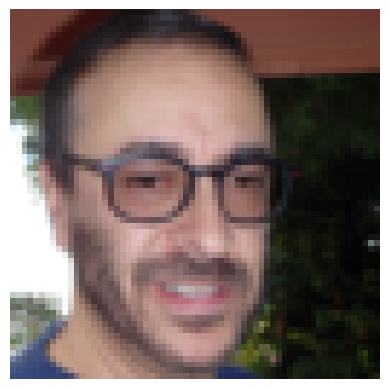

In [ ]:
# Денормализуем для картинок
plt.imshow(denorm(next(iter(dataloader))[0][0]).cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()).to(device)

In [ ]:
latent_size = 256
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
).to(device)

In [ ]:
# lr = 0.0001
lr = 0.0002

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss().to(device),
    "generator": nn.BCELoss().to(device)
}

In [ ]:
def show_generated(n_images: int=4):
  with torch.no_grad():
    fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
    model["generator"].eval()
    fake_images = denorm(model["generator"](fixed_latent))

    fake_images = fake_images.detach().cpu().permute(0, 2, 3, 1).numpy()
    n = fake_images.shape[0]
    fig, axes = plt.subplots(1, n, figsize=(2 * n, 2))
    for i in range(n):
      axes[i].imshow(fake_images[i])
      axes[i].axis('off')

    plt.show()

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(device)
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            # real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            # fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_targets = torch.FloatTensor(fake_images.size(0), 1).uniform_(0.0, 0.05).to(device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            # targets = torch.ones(batch_size, 1, device=device)
            targets = torch.FloatTensor(fake_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        if (epoch + 1) % 5 == 0:
            show_generated(n_images=4)

    return losses_g, losses_d, real_scores, fake_scores

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 6.3671, loss_d: 0.3529, real_score: 0.9379, fake_score: 0.0692


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 6.4983, loss_d: 0.5087, real_score: 0.8969, fake_score: 0.1042


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 5.6500, loss_d: 0.5141, real_score: 0.8662, fake_score: 0.1337


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 4.2380, loss_d: 0.4335, real_score: 0.8745, fake_score: 0.1203


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 4.1782, loss_d: 0.6682, real_score: 0.8166, fake_score: 0.1722


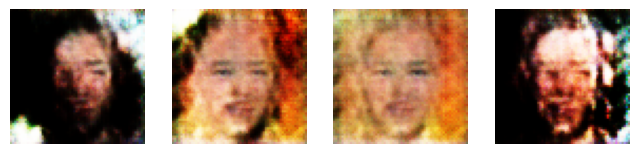

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 4.7038, loss_d: 0.5098, real_score: 0.8539, fake_score: 0.1483


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 4.8349, loss_d: 0.5850, real_score: 0.8363, fake_score: 0.1716


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 4.5689, loss_d: 0.5259, real_score: 0.8340, fake_score: 0.1526


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.8434, loss_d: 0.6198, real_score: 0.8162, fake_score: 0.1765


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 4.5404, loss_d: 0.5157, real_score: 0.8427, fake_score: 0.1572


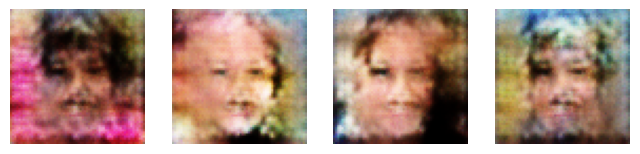

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 4.7387, loss_d: 0.6144, real_score: 0.8237, fake_score: 0.1691


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 4.1965, loss_d: 0.5044, real_score: 0.8506, fake_score: 0.1598


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 4.3175, loss_d: 0.6135, real_score: 0.8209, fake_score: 0.1746


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 4.8820, loss_d: 0.5592, real_score: 0.8352, fake_score: 0.1695


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 4.6301, loss_d: 0.4581, real_score: 0.8613, fake_score: 0.1383


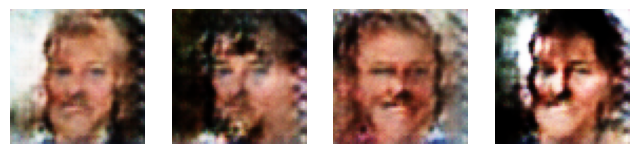

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 4.9914, loss_d: 0.7136, real_score: 0.8114, fake_score: 0.1898


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 4.7879, loss_d: 0.4998, real_score: 0.8538, fake_score: 0.1458


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 4.5872, loss_d: 0.7144, real_score: 0.7950, fake_score: 0.1938


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 4.2569, loss_d: 0.5472, real_score: 0.8245, fake_score: 0.1660


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 4.7415, loss_d: 0.6003, real_score: 0.8258, fake_score: 0.1720


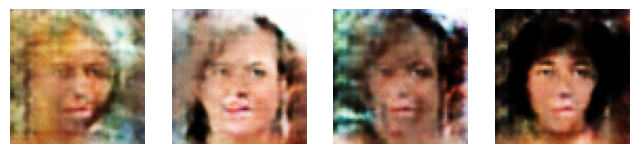

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 4.0117, loss_d: 0.5154, real_score: 0.8414, fake_score: 0.1578


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 4.3376, loss_d: 0.4766, real_score: 0.8560, fake_score: 0.1479


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 4.3779, loss_d: 0.4977, real_score: 0.8537, fake_score: 0.1523


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 4.7319, loss_d: 0.6293, real_score: 0.8183, fake_score: 0.1633


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 4.1395, loss_d: 0.5804, real_score: 0.8371, fake_score: 0.1749


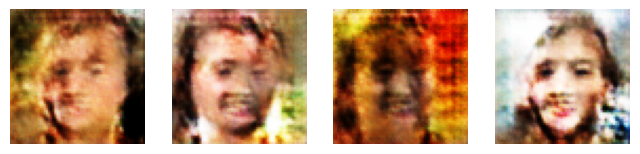

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 4.3744, loss_d: 0.5779, real_score: 0.8284, fake_score: 0.1689


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 4.1001, loss_d: 0.5029, real_score: 0.8477, fake_score: 0.1503


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 4.0822, loss_d: 0.4602, real_score: 0.8604, fake_score: 0.1404


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 4.3619, loss_d: 0.5214, real_score: 0.8441, fake_score: 0.1496


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.2190, loss_d: 0.5629, real_score: 0.8344, fake_score: 0.1663


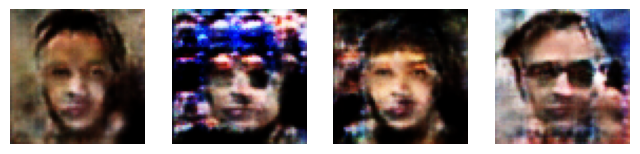

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.1082, loss_d: 0.5175, real_score: 0.8486, fake_score: 0.1519


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.8878, loss_d: 0.4762, real_score: 0.8518, fake_score: 0.1369


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 4.1671, loss_d: 0.5258, real_score: 0.8472, fake_score: 0.1596


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 4.1782, loss_d: 0.4794, real_score: 0.8526, fake_score: 0.1451


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 4.5056, loss_d: 0.5178, real_score: 0.8501, fake_score: 0.1492


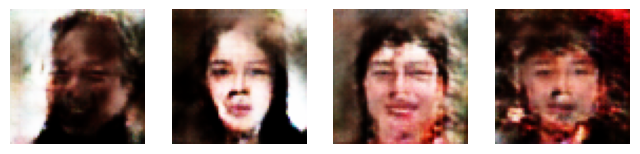

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 4.2257, loss_d: 0.5743, real_score: 0.8361, fake_score: 0.1767


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 4.1443, loss_d: 0.6301, real_score: 0.8142, fake_score: 0.1720


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 3.9829, loss_d: 0.4629, real_score: 0.8538, fake_score: 0.1452


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 4.2653, loss_d: 0.4972, real_score: 0.8509, fake_score: 0.1511


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 4.4428, loss_d: 0.4989, real_score: 0.8516, fake_score: 0.1481


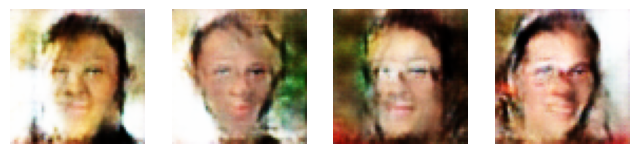

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.1326, loss_d: 0.4694, real_score: 0.8581, fake_score: 0.1380


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 4.3473, loss_d: 0.7733, real_score: 0.7854, fake_score: 0.2074


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 4.1562, loss_d: 0.5114, real_score: 0.8433, fake_score: 0.1621


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 4.1011, loss_d: 0.4703, real_score: 0.8581, fake_score: 0.1474


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 4.0640, loss_d: 0.4732, real_score: 0.8579, fake_score: 0.1366


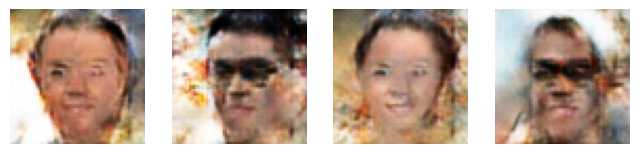

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 4.0337, loss_d: 0.5433, real_score: 0.8440, fake_score: 0.1510


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 4.2164, loss_d: 0.7013, real_score: 0.7996, fake_score: 0.1990


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.7819, loss_d: 0.4582, real_score: 0.8526, fake_score: 0.1442


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 4.1101, loss_d: 0.4602, real_score: 0.8647, fake_score: 0.1429


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 4.3665, loss_d: 0.4910, real_score: 0.8510, fake_score: 0.1345


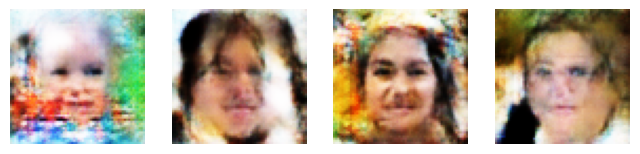

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 4.1897, loss_d: 0.6240, real_score: 0.8248, fake_score: 0.1747


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.2731, loss_d: 0.5571, real_score: 0.8461, fake_score: 0.1706


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.1414, loss_d: 0.5732, real_score: 0.8239, fake_score: 0.1654


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 3.5393, loss_d: 0.4583, real_score: 0.8550, fake_score: 0.1397


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.7041, loss_d: 0.4478, real_score: 0.8626, fake_score: 0.1413


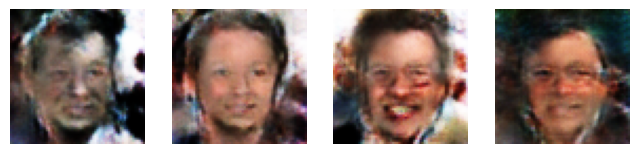

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 3.8213, loss_d: 0.4229, real_score: 0.8707, fake_score: 0.1300


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 3.9187, loss_d: 0.6427, real_score: 0.8202, fake_score: 0.1570


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.1069, loss_d: 0.5970, real_score: 0.8336, fake_score: 0.1819


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.1706, loss_d: 0.6430, real_score: 0.8101, fake_score: 0.1804


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 4.0319, loss_d: 0.5316, real_score: 0.8446, fake_score: 0.1633


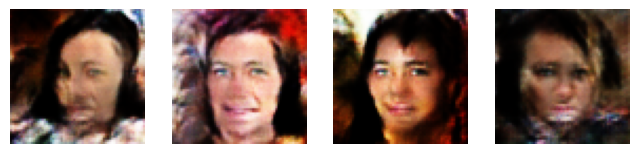

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 3.2964, loss_d: 0.4078, real_score: 0.8746, fake_score: 0.1242


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 3.6543, loss_d: 0.4073, real_score: 0.8770, fake_score: 0.1204


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.9248, loss_d: 0.4488, real_score: 0.8657, fake_score: 0.1370


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 3.6370, loss_d: 0.4599, real_score: 0.8586, fake_score: 0.1336


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.8173, loss_d: 1.0282, real_score: 0.7577, fake_score: 0.2343


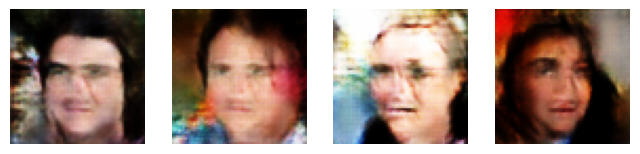

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.8592, loss_d: 0.6402, real_score: 0.8059, fake_score: 0.2073


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 3.7032, loss_d: 0.4867, real_score: 0.8492, fake_score: 0.1473


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.4825, loss_d: 0.4092, real_score: 0.8751, fake_score: 0.1222


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.4465, loss_d: 0.3971, real_score: 0.8799, fake_score: 0.1252


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 3.6883, loss_d: 0.4165, real_score: 0.8777, fake_score: 0.1230


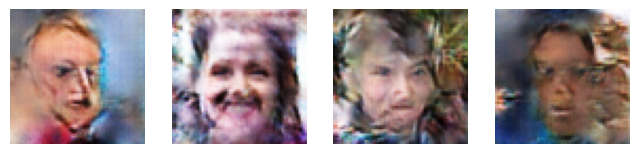

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.6685, loss_d: 0.4604, real_score: 0.8634, fake_score: 0.1323


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 3.5868, loss_d: 0.4412, real_score: 0.8726, fake_score: 0.1308


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 3.8218, loss_d: 0.4161, real_score: 0.8771, fake_score: 0.1181


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 4.3311, loss_d: 0.8277, real_score: 0.7810, fake_score: 0.2155


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 3.4161, loss_d: 0.4963, real_score: 0.8443, fake_score: 0.1483


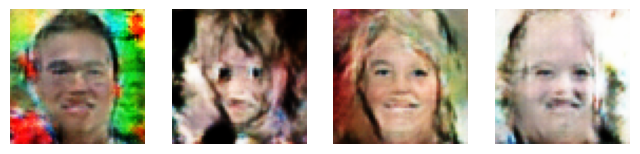

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 3.6976, loss_d: 0.4478, real_score: 0.8694, fake_score: 0.1384


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.0196, loss_d: 0.6358, real_score: 0.8293, fake_score: 0.1677


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 3.8572, loss_d: 0.5289, real_score: 0.8433, fake_score: 0.1593


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 3.4026, loss_d: 0.4024, real_score: 0.8771, fake_score: 0.1220


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 3.4311, loss_d: 0.3815, real_score: 0.8874, fake_score: 0.1125


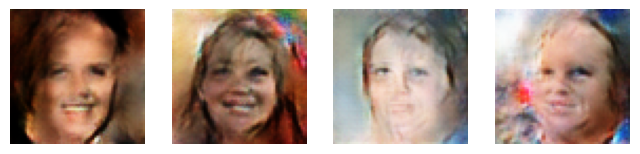

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 3.8321, loss_d: 0.4297, real_score: 0.8746, fake_score: 0.1253


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 3.2988, loss_d: 0.3690, real_score: 0.8913, fake_score: 0.1067


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 3.3393, loss_d: 0.3868, real_score: 0.8835, fake_score: 0.1067


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 3.8415, loss_d: 0.4736, real_score: 0.8678, fake_score: 0.1406


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.1823, loss_d: 0.7187, real_score: 0.8067, fake_score: 0.1962


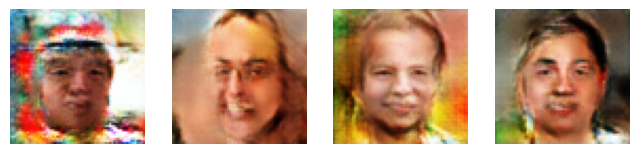

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 3.6000, loss_d: 0.5538, real_score: 0.8402, fake_score: 0.1518


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 3.5813, loss_d: 0.3976, real_score: 0.8788, fake_score: 0.1211


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 3.6687, loss_d: 0.3810, real_score: 0.8906, fake_score: 0.1110


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 3.6507, loss_d: 0.4082, real_score: 0.8832, fake_score: 0.1155


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 3.7364, loss_d: 0.4247, real_score: 0.8795, fake_score: 0.1219


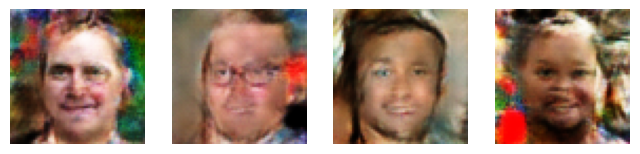

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 3.4895, loss_d: 0.4115, real_score: 0.8871, fake_score: 0.1132


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 3.5500, loss_d: 0.3620, real_score: 0.8994, fake_score: 0.0960


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 3.5149, loss_d: 0.3995, real_score: 0.8834, fake_score: 0.1099


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 4.1864, loss_d: 1.0770, real_score: 0.7496, fake_score: 0.2529


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 3.4198, loss_d: 0.4543, real_score: 0.8642, fake_score: 0.1402


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 3.3314, loss_d: 0.3747, real_score: 0.8913, fake_score: 0.1116


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 3.4183, loss_d: 0.3551, real_score: 0.8979, fake_score: 0.0993


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 3.3926, loss_d: 0.3506, real_score: 0.9014, fake_score: 0.0981


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 3.3629, loss_d: 0.3622, real_score: 0.8967, fake_score: 0.0972


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 3.4851, loss_d: 0.3826, real_score: 0.8961, fake_score: 0.1054


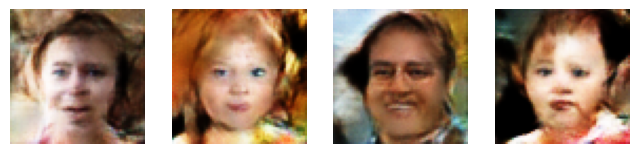

In [ ]:
losses_g, losses_d, real_scores, fake_scores = fit(model, criterion, 100, lr)

In [ ]:
torch.save(model['discriminator'].cpu().state_dict(), 'disc_5')
torch.save(model['generator'].cpu().state_dict(), 'gen_5')
model['discriminator'].to(device)
model['generator'].to(device)
pass

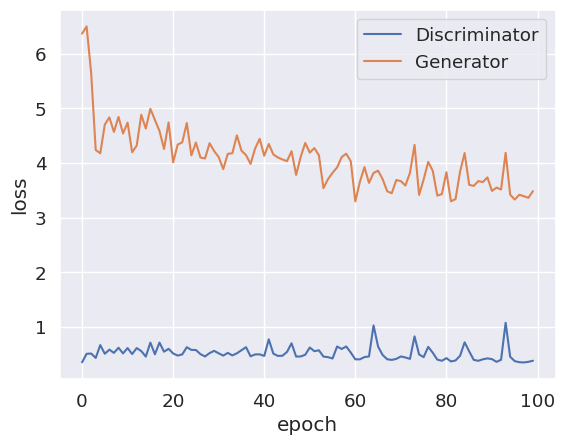

In [ ]:
plt.plot(losses_d)
plt.plot(losses_g)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.show()

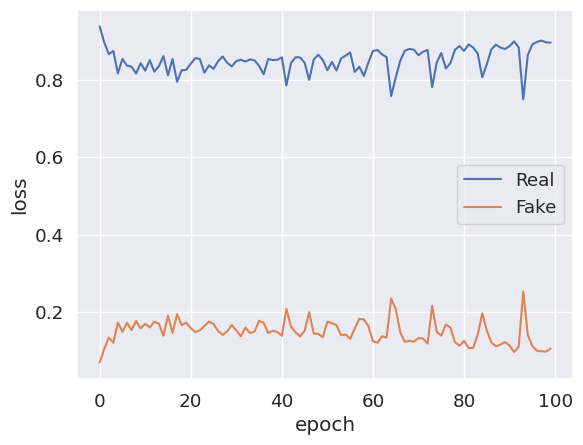

In [ ]:
plt.plot(real_scores)
plt.plot(fake_scores)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Real', 'Fake'])
plt.show()

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 5.2210, loss_d: 0.3250, real_score: 0.9638, fake_score: 0.0571


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 7.6439, loss_d: 0.3802, real_score: 0.9598, fake_score: 0.0459


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 8.3264, loss_d: 0.4160, real_score: 0.9512, fake_score: 0.0548


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 8.9364, loss_d: 0.4778, real_score: 0.9299, fake_score: 0.0675


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 5.5141, loss_d: 0.3317, real_score: 0.9441, fake_score: 0.0573


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.5395, loss_d: 0.3738, real_score: 0.9275, fake_score: 0.0708


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 5.7834, loss_d: 0.3727, real_score: 0.9238, fake_score: 0.0680


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 4.4952, loss_d: 0.2861, real_score: 0.9561, fake_score: 0.0487


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.9173, loss_d: 0.3014, real_score: 0.9528, fake_score: 0.0476


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 5.5550, loss_d: 0.3264, real_score: 0.9460, fake_score: 0.0552


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 5.1430, loss_d: 0.3120, real_score: 0.9442, fake_score: 0.0534


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 5.5896, loss_d: 0.2954, real_score: 0.9545, fake_score: 0.0510


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 6.2357, loss_d: 0.3470, real_score: 0.9492, fake_score: 0.0462


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 5.5984, loss_d: 0.2868, real_score: 0.9575, fake_score: 0.0413


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 7.4238, loss_d: 0.3604, real_score: 0.9533, fake_score: 0.0481


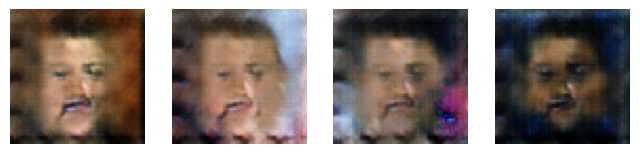

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 5.1870, loss_d: 0.2772, real_score: 0.9595, fake_score: 0.0396


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 4.6276, loss_d: 0.2659, real_score: 0.9609, fake_score: 0.0382


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 6.6295, loss_d: 0.4537, real_score: 0.9189, fake_score: 0.0790


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 5.0597, loss_d: 0.2943, real_score: 0.9516, fake_score: 0.0498


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 5.5631, loss_d: 0.2910, real_score: 0.9559, fake_score: 0.0464


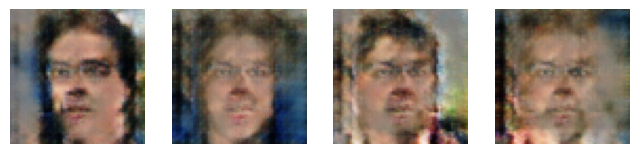

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 5.1054, loss_d: 0.2782, real_score: 0.9601, fake_score: 0.0373


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 5.0843, loss_d: 0.2730, real_score: 0.9616, fake_score: 0.0392


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 6.2152, loss_d: 0.3038, real_score: 0.9583, fake_score: 0.0391


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 4.6519, loss_d: 0.2678, real_score: 0.9626, fake_score: 0.0394


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 4.6953, loss_d: 0.2706, real_score: 0.9630, fake_score: 0.0348


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 5.1291, loss_d: 0.2829, real_score: 0.9639, fake_score: 0.0398


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 5.2981, loss_d: 0.2871, real_score: 0.9663, fake_score: 0.0311


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 5.5068, loss_d: 0.2936, real_score: 0.9561, fake_score: 0.0398


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 5.5536, loss_d: 0.3028, real_score: 0.9628, fake_score: 0.0401


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.4020, loss_d: 0.2654, real_score: 0.9678, fake_score: 0.0331


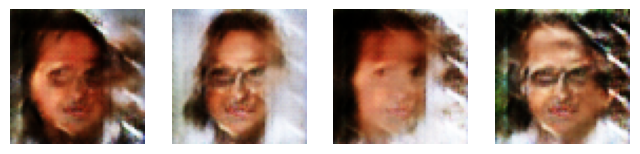

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.4761, loss_d: 0.2664, real_score: 0.9635, fake_score: 0.0345


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.5047, loss_d: 0.2609, real_score: 0.9672, fake_score: 0.0323


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 4.7013, loss_d: 0.2590, real_score: 0.9681, fake_score: 0.0336


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 9.2886, loss_d: 0.4704, real_score: 0.9416, fake_score: 0.0565


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 4.8687, loss_d: 0.2856, real_score: 0.9592, fake_score: 0.0420


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 5.1160, loss_d: 0.2727, real_score: 0.9621, fake_score: 0.0396


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 6.5877, loss_d: 0.3492, real_score: 0.9500, fake_score: 0.0476


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 5.4377, loss_d: 0.2852, real_score: 0.9639, fake_score: 0.0372


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 4.6113, loss_d: 0.2678, real_score: 0.9611, fake_score: 0.0394


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 4.4329, loss_d: 0.2680, real_score: 0.9610, fake_score: 0.0379


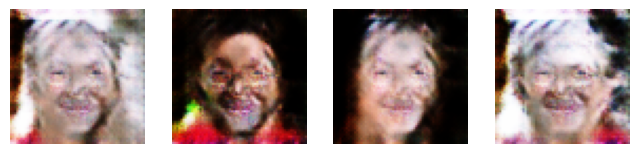

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.5572, loss_d: 0.2669, real_score: 0.9605, fake_score: 0.0396


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 4.5244, loss_d: 0.2869, real_score: 0.9574, fake_score: 0.0430


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 4.1458, loss_d: 0.2617, real_score: 0.9619, fake_score: 0.0355


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 4.3481, loss_d: 0.2630, real_score: 0.9651, fake_score: 0.0366


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 4.5635, loss_d: 0.2745, real_score: 0.9628, fake_score: 0.0384


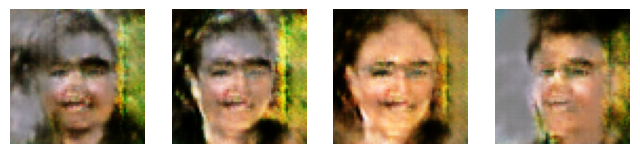

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 4.6460, loss_d: 0.2704, real_score: 0.9610, fake_score: 0.0394


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 4.5556, loss_d: 0.2661, real_score: 0.9592, fake_score: 0.0351


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 5.5119, loss_d: 0.3036, real_score: 0.9634, fake_score: 0.0379


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 5.2801, loss_d: 0.2868, real_score: 0.9623, fake_score: 0.0383


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 4.6494, loss_d: 0.2674, real_score: 0.9653, fake_score: 0.0362


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 4.5171, loss_d: 0.2626, real_score: 0.9631, fake_score: 0.0367


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.7120, loss_d: 0.2638, real_score: 0.9658, fake_score: 0.0352


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.6381, loss_d: 0.2728, real_score: 0.9621, fake_score: 0.0318


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 4.6742, loss_d: 0.2806, real_score: 0.9644, fake_score: 0.0357


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 7.4170, loss_d: 0.7273, real_score: 0.8833, fake_score: 0.1188


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 4.8540, loss_d: 0.3049, real_score: 0.9458, fake_score: 0.0529


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 6.7061, loss_d: 0.5505, real_score: 0.9030, fake_score: 0.1059


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 5.1127, loss_d: 0.3310, real_score: 0.9409, fake_score: 0.0555


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.8467, loss_d: 0.2855, real_score: 0.9478, fake_score: 0.0522


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 4.8650, loss_d: 0.2795, real_score: 0.9576, fake_score: 0.0425


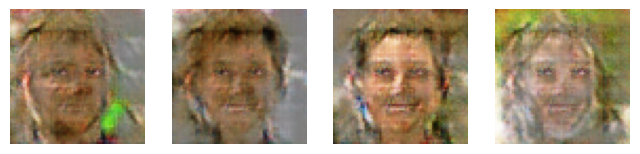

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 4.8311, loss_d: 0.2743, real_score: 0.9572, fake_score: 0.0444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 4.4478, loss_d: 0.2681, real_score: 0.9560, fake_score: 0.0417


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 4.8163, loss_d: 0.2749, real_score: 0.9579, fake_score: 0.0419


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 4.5592, loss_d: 0.2822, real_score: 0.9529, fake_score: 0.0436


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 4.4896, loss_d: 0.2760, real_score: 0.9545, fake_score: 0.0454


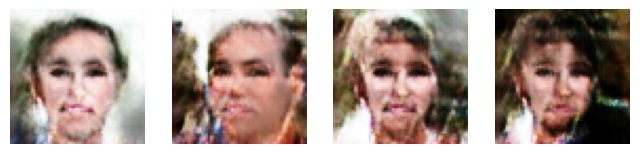

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 4.2646, loss_d: 0.2618, real_score: 0.9593, fake_score: 0.0421


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 4.1758, loss_d: 0.2660, real_score: 0.9596, fake_score: 0.0391


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.3696, loss_d: 0.2720, real_score: 0.9570, fake_score: 0.0405


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 4.6722, loss_d: 0.2766, real_score: 0.9599, fake_score: 0.0423


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.6791, loss_d: 0.2898, real_score: 0.9565, fake_score: 0.0455


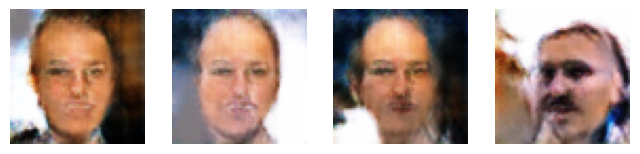

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 4.3300, loss_d: 0.2729, real_score: 0.9589, fake_score: 0.0383


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.2522, loss_d: 0.2624, real_score: 0.9618, fake_score: 0.0383


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 4.4795, loss_d: 0.2583, real_score: 0.9632, fake_score: 0.0380


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 5.5362, loss_d: 0.3290, real_score: 0.9442, fake_score: 0.0484


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 7.3492, loss_d: 0.7511, real_score: 0.8876, fake_score: 0.1087


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 7.1886, loss_d: 0.7722, real_score: 0.8706, fake_score: 0.1479


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.9944, loss_d: 0.3980, real_score: 0.9044, fake_score: 0.0902


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 4.7398, loss_d: 0.3340, real_score: 0.9232, fake_score: 0.0756


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.8469, loss_d: 0.3045, real_score: 0.9426, fake_score: 0.0615


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 4.7588, loss_d: 0.2925, real_score: 0.9433, fake_score: 0.0597


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 4.7732, loss_d: 0.3266, real_score: 0.9349, fake_score: 0.0681


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.4072, loss_d: 0.3391, real_score: 0.9263, fake_score: 0.0619


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 4.5675, loss_d: 0.2864, real_score: 0.9448, fake_score: 0.0537


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 4.5975, loss_d: 0.2780, real_score: 0.9476, fake_score: 0.0520


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.9796, loss_d: 0.2874, real_score: 0.9485, fake_score: 0.0468


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.9528, loss_d: 0.2956, real_score: 0.9544, fake_score: 0.0523


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 4.3452, loss_d: 0.2663, real_score: 0.9592, fake_score: 0.0394


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.7597, loss_d: 0.2817, real_score: 0.9554, fake_score: 0.0415


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 4.7553, loss_d: 0.2746, real_score: 0.9611, fake_score: 0.0413


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.3885, loss_d: 0.2727, real_score: 0.9562, fake_score: 0.0434


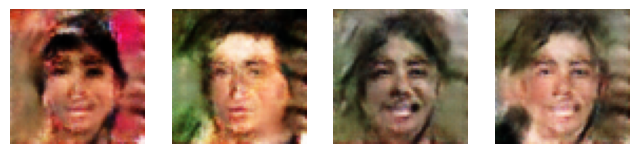

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 4.5545, loss_d: 0.2913, real_score: 0.9491, fake_score: 0.0472


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 4.4799, loss_d: 0.2672, real_score: 0.9604, fake_score: 0.0419


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 5.3853, loss_d: 0.3141, real_score: 0.9501, fake_score: 0.0487


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 4.8510, loss_d: 0.2878, real_score: 0.9546, fake_score: 0.0430


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.4599, loss_d: 0.2730, real_score: 0.9585, fake_score: 0.0444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 4.6190, loss_d: 0.2843, real_score: 0.9488, fake_score: 0.0466


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 5.0903, loss_d: 0.3080, real_score: 0.9511, fake_score: 0.0481


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 4.4799, loss_d: 0.2795, real_score: 0.9546, fake_score: 0.0443


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 4.3454, loss_d: 0.2747, real_score: 0.9567, fake_score: 0.0436


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 4.2422, loss_d: 0.2679, real_score: 0.9576, fake_score: 0.0450


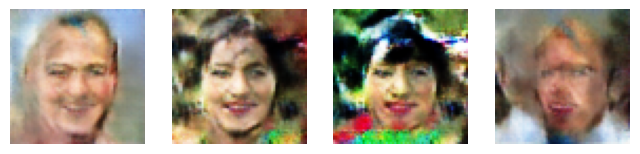

In [ ]:
losses_g, losses_d, real_scores, fake_scores = fit(model, criterion, 100, lr)

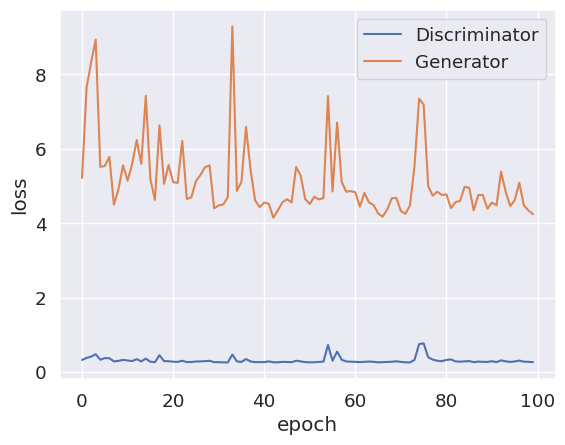

In [ ]:
plt.plot(losses_d)
plt.plot(losses_g)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.show()

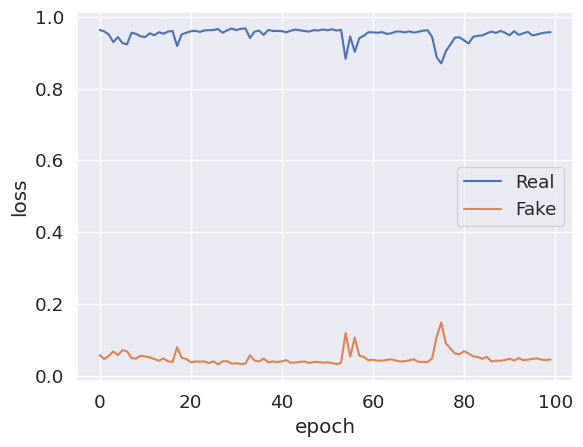

In [ ]:
plt.plot(real_scores)
plt.plot(fake_scores)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Real', 'Fake'])
plt.show()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

Ровный график у дискриминатора. График генератора немного болтается. График точности получился хороший.

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
model["generator"].eval()
fake_images = model["generator"](fixed_latent)

In [ ]:
def show_images(generated):
  # TODO: show generated images
  generated = denorm(generated.detach()).cpu().permute(0, 2, 3, 1).numpy()
  n = generated.shape[0]
  fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))
  for i in range(n):
    axes[i].imshow(generated[i])
    axes[i].axis('off')

  plt.show()

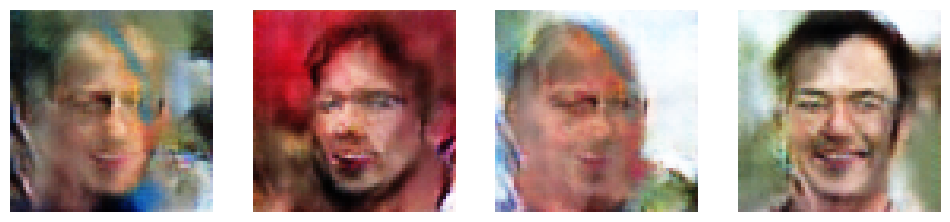

In [ ]:
show_images(fake_images)

Как вам качество получившихся изображений?

Получилось примерно, как и у автоэнкодеров, почему-то. При этом, это лучшее, что удалось получить.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

def knn_accuracy(real_images, fake_images):
  real_images = real_images.view(real_images.size(0), -1).cpu().detach().numpy()
  fake_images = fake_images.view(fake_images.size(0), -1).cpu().detach().numpy()

  n_real = real_images.shape[0]
  n_fake = fake_images.shape[0]

  X = np.concatenate([real_images, fake_images], axis=0)
  y = np.concatenate([np.ones(n_real), np.zeros(n_fake)])

  splitter = LeaveOneOut()
  correct = 0

  for train_index, test_index in splitter.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    if y_pred == y_test:
      correct += 1

  accuracy = correct / (n_real + n_fake)
  return accuracy

In [ ]:
batch_count = 4
real_images = []
batch_i = 0
for batch, _ in dataloader:
  batch = batch.to(device)
  real_images.append(batch)
  batch_i += 1
  if batch_i == batch_count:
    break
real_images = torch.cat(real_images, dim=0).to(device)

model["generator"].eval()
with torch.no_grad():
  latent = torch.randn(batch_count * batch_size, latent_size, 1, 1, device=device)
  fake_images = model["generator"](latent)

In [ ]:
accuracy = knn_accuracy(real_images, fake_images)
print(f"Leave-One-Out Accuracy: {accuracy:.4f}")

Leave-One-Out Accuracy: 0.7852


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

В идеале должен быть около 0.5, что означало бы, что генератор делает очень реалистичные лица.

Если бы точность была равна 1,то это означало бы, что сгенерированные и реальные фото легко различимы, что плохо.

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE

real_images_flatten = real_images.view(real_images.size(0), -1).cpu().detach().numpy()
fake_images_flatten = fake_images.view(fake_images.size(0), -1).cpu().detach().numpy()

n_real = real_images_flatten.shape[0]
n_fake = fake_images_flatten.shape[0]

images = np.concatenate([real_images_flatten, fake_images_flatten], axis=0)
labels = np.concatenate([np.ones(n_real), np.zeros(n_fake)])

tsne = TSNE(n_components=2, random_state=42)
images_2d = tsne.fit_transform(images)

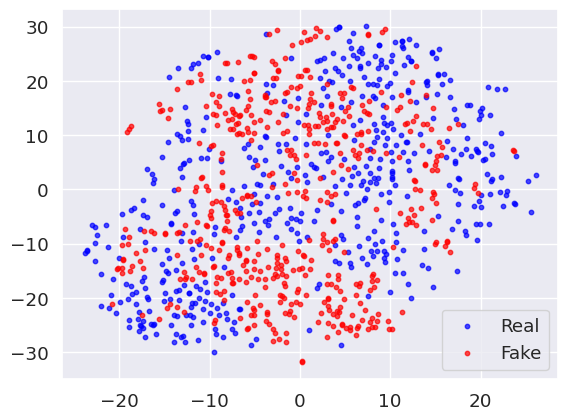

In [ ]:
plt.scatter(
    images_2d[labels == 1, 0], images_2d[labels == 1, 1],
    label="Real", alpha=0.7, c='blue', s=10
)
plt.scatter(
    images_2d[labels == 0, 0], images_2d[labels == 0, 1],
    label="Fake", alpha=0.7, c='red', s=10
)
plt.legend()
plt.show()

Прокомментируйте получившийся результат:

Точки представлены одной группой, что хорошо. Однако вспоминая сами картинки, то приходим к тому, что это не очень хороший способ определить качество генерации.

In [ ]:
# Большая ячейка, чтобы в pdf было всё













































